In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

# DCA (Discrete Choice Approach)

In [3]:
# Given Parameters
params_dca = {'mu' : 0.01, 
              'beta' : 1, 
              'phi' : 1.00, 
              'chi' : 1.20, 
              'eta' : 0.991
             }

In [4]:
def switch(runType):
    alpha_w = 1580
    alpha_O = 0
    alpha_p = 0
    sigma_f = 0.681
    sigma_c = 1.724
    
    if runType == 'WP': # wealth and predisposition
        alpha_w = 2668
        alpha_O = 2.1
    elif runType == 'WM': # wealth misalignment
        # this case is not in the FW set: just testing the
        alpha_w = 1580
        alpha_p = 500
    elif runType == 'CN': # common noise
        mean_sig = (sigma_f + sigma_c)/2
        sigma_f = mean_sig
        sigma_c = mean_sig
    return alpha_w, alpha_O, alpha_p, sigma_f, sigma_c

In [5]:
def run_simple_model_dca(params, runType, T = 7000):
    
    alpha_w, alpha_O, alpha_p, sigma_f, sigma_c = switch(runType)
    
    P = np.zeros([T+1,1])
    pstar = 0

    Df = np.zeros([T,1])
    Dc = np.zeros([T,1])

    Nf = np.zeros([T,1])
    Nc = np.zeros([T,1])

    rf = np.zeros([T,1])
    rc = np.zeros([T,1])

    Wf = np.zeros([T,1])
    Wc = np.zeros([T,1])

    A = np.zeros([T,1])
    
    # initial values(not given)
    Nf[0:2] = 0.5
    Nc[0:2] = 0.5
    
    for t in range(2, T):

        #portfolio performance
        rf[t] = ( np.exp(P[t]) - np.exp(P[t-1]) ) * Df[t-2]
        rc[t] = ( np.exp(P[t]) - np.exp(P[t-1]) ) * Dc[t-2]

        #summarize performance over time
        Wf[t] = params['eta'] * Wf[t-1] + (1 - params['eta']) * rf[t]
        Wc[t] = params['eta'] * Wc[t-1] + (1 - params['eta']) * rc[t]

        # type fractions
        Nf[t] = 1 / ( 1 + np.exp(-params['beta'] * A[t-1]))
        Nc[t] = 1 - Nf[t]

        # The A[t] dynamic is set up to handle several models
        A[t] = alpha_w * (Wf[t] - Wc[t]) + alpha_O + alpha_p * (pstar - P[t]) ** 2

        # demands
        Df[t] = params['phi'] * ( pstar - P[t] ) + sigma_f * np.random.randn(1)
        Dc[t] = params['chi'] * ( P[t] - P[t-1] ) + sigma_c * np.random.randn(1)

        # pricing
        P[t+1] = P[t] + params['mu'] * ( Nf[t] * Df[t] + Nc[t] * Dc[t] )

    # returns
    rr = P[1:T+1] - P[0:T]
    
    return [P, rr, Nc, Nf]

In [6]:
returns_dca = []
prices_dca = []
results_dict = {'Skew': [], 'Kurtosis' : [], 'Sum(ACF)' : []}

## Wealth

In [7]:
results = run_simple_model_dca(params_dca, runType = 'W')
P, rr = results[0], results[1]
prices_dca.append(P)
returns_dca.append(rr)
results_dict['Skew'].append(stats.skew(rr)[0])
results_dict['Kurtosis'].append(stats.kurtosis(rr)[0])
results_dict['Sum(ACF)'].append(np.sum(acf(abs(rr), unbiased=True, nlags=250)))

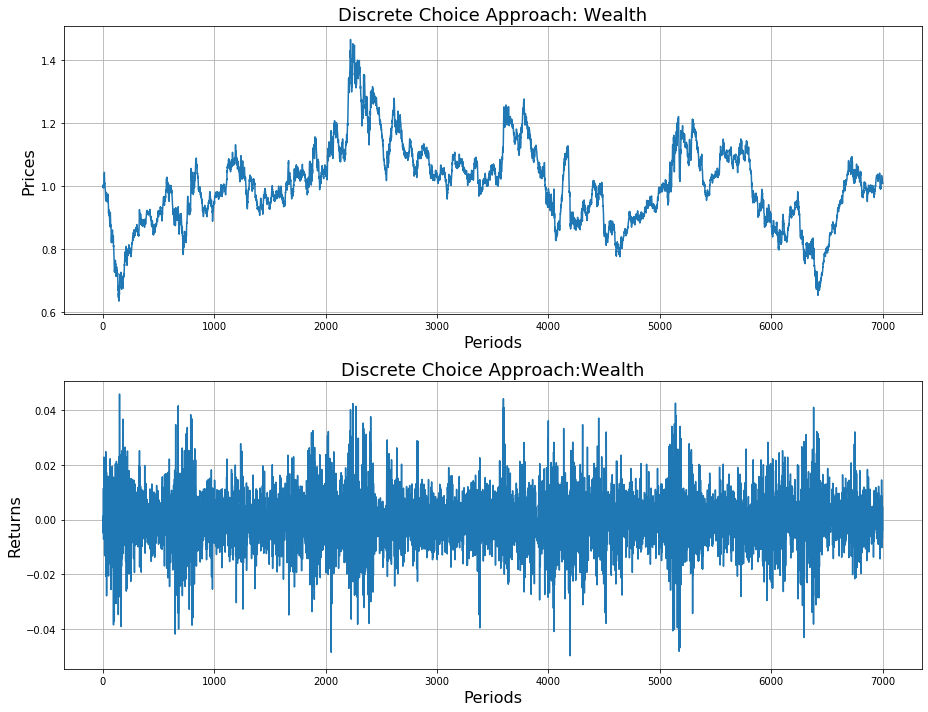

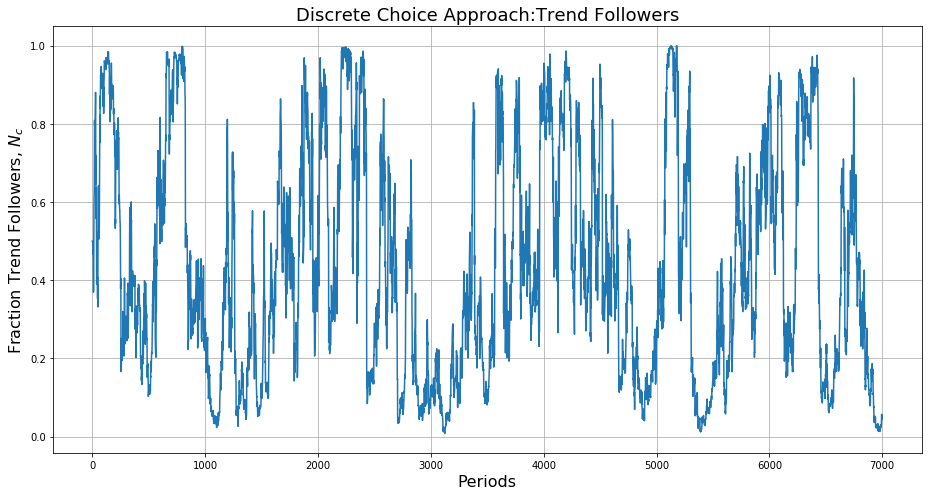

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

axes[0].plot(range(len(P[1:])), np.exp(P[1:]))
axes[0].set_xlabel('Periods', fontsize=16)
axes[0].set_ylabel('Prices', fontsize=16)
axes[0].set_title('Discrete Choice Approach: Wealth', fontsize=18)
axes[0].grid()

axes[1].plot(range(len(rr)), rr)
axes[1].set_xlabel('Periods', fontsize=16)
axes[1].set_ylabel('Returns', fontsize=16)
axes[1].set_title('Discrete Choice Approach:Wealth', fontsize=18)
axes[1].grid()

fig.tight_layout()

fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes1.plot(range(len(rr)), results[2])
axes1.set_xlabel('Periods', fontsize=16)
axes1.set_ylabel('Fraction Trend Followers, $N_{c}$', fontsize=16)
axes1.set_title('Discrete Choice Approach:Trend Followers', fontsize=18)
axes1.grid()

fig1.tight_layout()

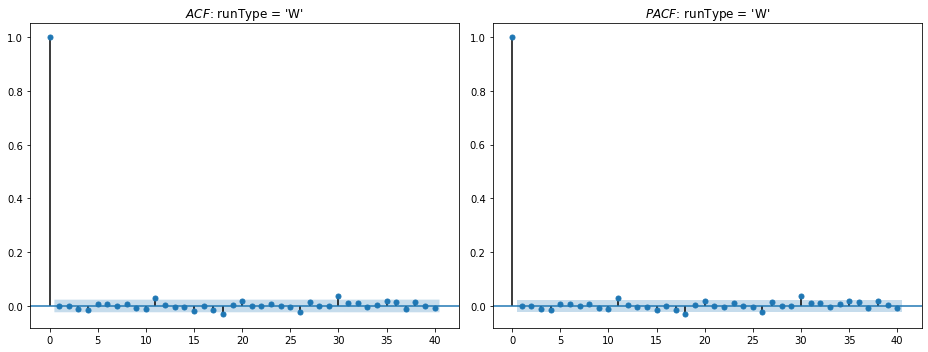

In [9]:
nlags = 40

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

plot_acf(rr,  ax=axes[0], lags=nlags, title="${\it ACF}$: runType = 'W'")
plot_pacf(rr, ax=axes[1], lags=nlags, title="${\it PACF}$: runType = 'W'")

fig.tight_layout()

## Wealth and Predisposition bias

In [10]:
results = run_simple_model_dca(params_dca, runType = 'WP')
P, rr = results[0], results[1]
prices_dca.append(P)
returns_dca.append(rr)
results_dict['Skew'].append(stats.skew(rr)[0])
results_dict['Kurtosis'].append(stats.kurtosis(rr)[0])
results_dict['Sum(ACF)'].append(np.sum(acf(abs(rr), unbiased=True, nlags=250)))

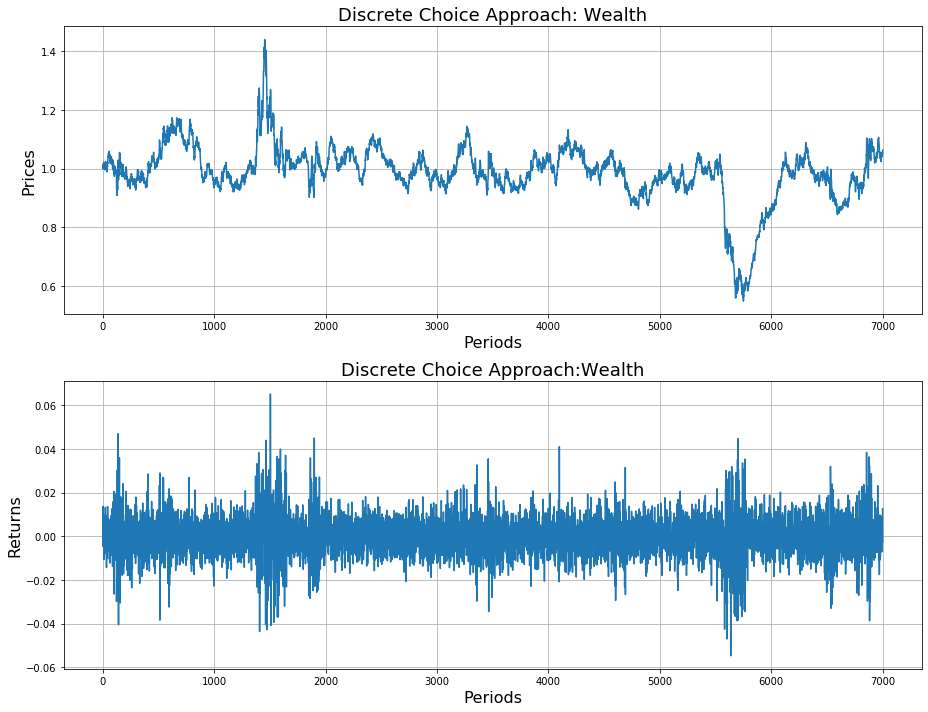

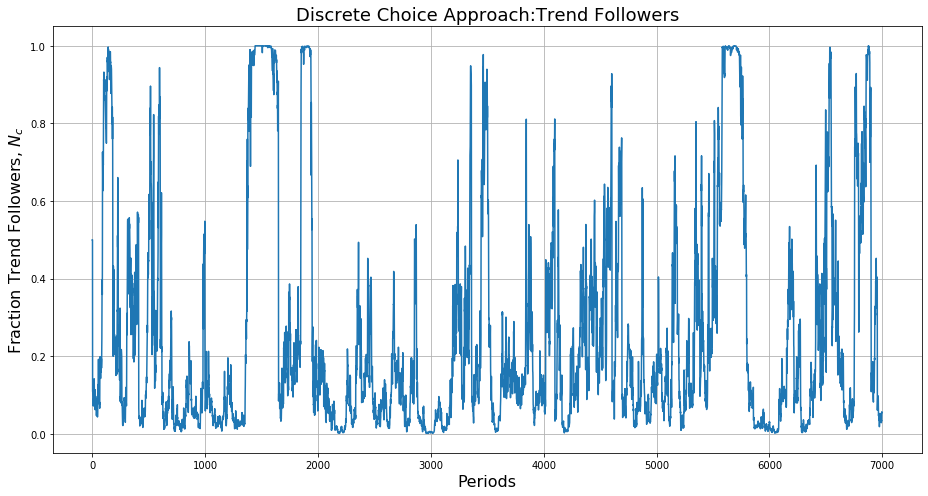

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

axes[0].plot(range(len(P[1:])), np.exp(P[1:]))
axes[0].set_xlabel('Periods', fontsize=16)
axes[0].set_ylabel('Prices', fontsize=16)
axes[0].set_title('Discrete Choice Approach: Wealth', fontsize=18)
axes[0].grid()

axes[1].plot(range(len(rr)), rr)
axes[1].set_xlabel('Periods', fontsize=16)
axes[1].set_ylabel('Returns', fontsize=16)
axes[1].set_title('Discrete Choice Approach:Wealth', fontsize=18)
axes[1].grid()

fig.tight_layout()

fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes1.plot(range(len(rr)), results[2])
axes1.set_xlabel('Periods', fontsize=16)
axes1.set_ylabel('Fraction Trend Followers, $N_{c}$', fontsize=16)
axes1.set_title('Discrete Choice Approach:Trend Followers', fontsize=18)
axes1.grid()

fig1.tight_layout()

## Wealth and Misalignment adjustment

In [12]:
results = run_simple_model_dca(params_dca, runType = 'WM')
P, rr = results[0], results[1]
prices_dca.append(P)
returns_dca.append(rr)
results_dict['Skew'].append(stats.skew(rr)[0])
results_dict['Kurtosis'].append(stats.kurtosis(rr)[0])
results_dict['Sum(ACF)'].append(np.sum(acf(abs(rr), unbiased=True, nlags=250)))

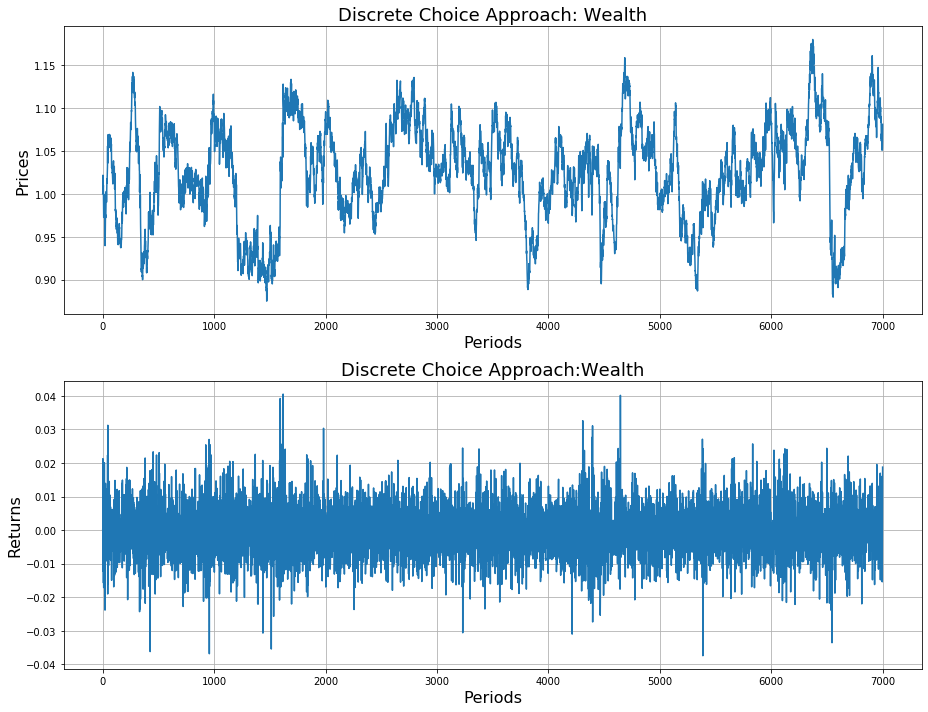

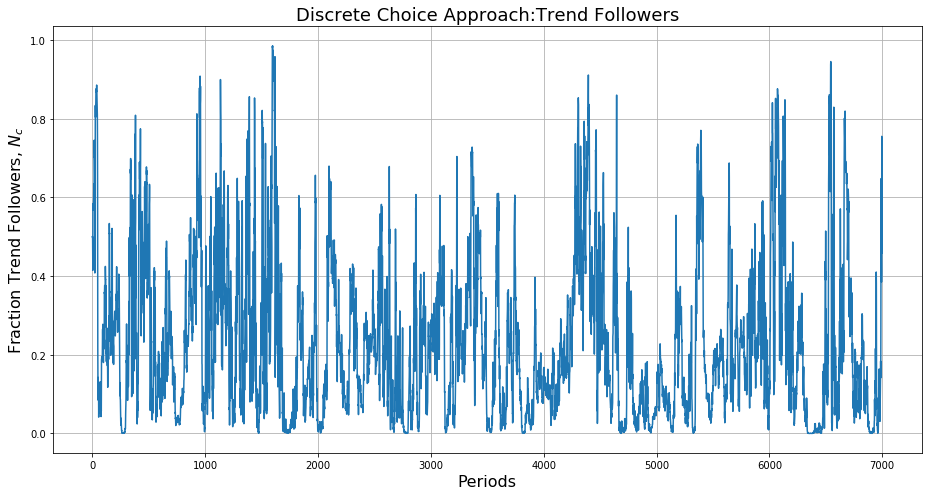

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

axes[0].plot(range(len(P[1:])), np.exp(P[1:]))
axes[0].set_xlabel('Periods', fontsize=16)
axes[0].set_ylabel('Prices', fontsize=16)
axes[0].set_title('Discrete Choice Approach: Wealth', fontsize=18)
axes[0].grid()

axes[1].plot(range(len(rr)), rr)
axes[1].set_xlabel('Periods', fontsize=16)
axes[1].set_ylabel('Returns', fontsize=16)
axes[1].set_title('Discrete Choice Approach:Wealth', fontsize=18)
axes[1].grid()

fig.tight_layout()

fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes1.plot(range(len(rr)), results[2])
axes1.set_xlabel('Periods', fontsize=16)
axes1.set_ylabel('Fraction Trend Followers, $N_{c}$', fontsize=16)
axes1.set_title('Discrete Choice Approach:Trend Followers', fontsize=18)
axes1.grid()

fig1.tight_layout()

## Wealth and Common noise distribution

In [14]:
results = run_simple_model_dca(params_dca, runType = 'CN')
P, rr = results[0], results[1]
prices_dca.append(P)
returns_dca.append(rr)
results_dict['Skew'].append(stats.skew(rr)[0])
results_dict['Kurtosis'].append(stats.kurtosis(rr)[0])
results_dict['Sum(ACF)'].append(np.sum(acf(abs(rr), unbiased=True, nlags=250)))

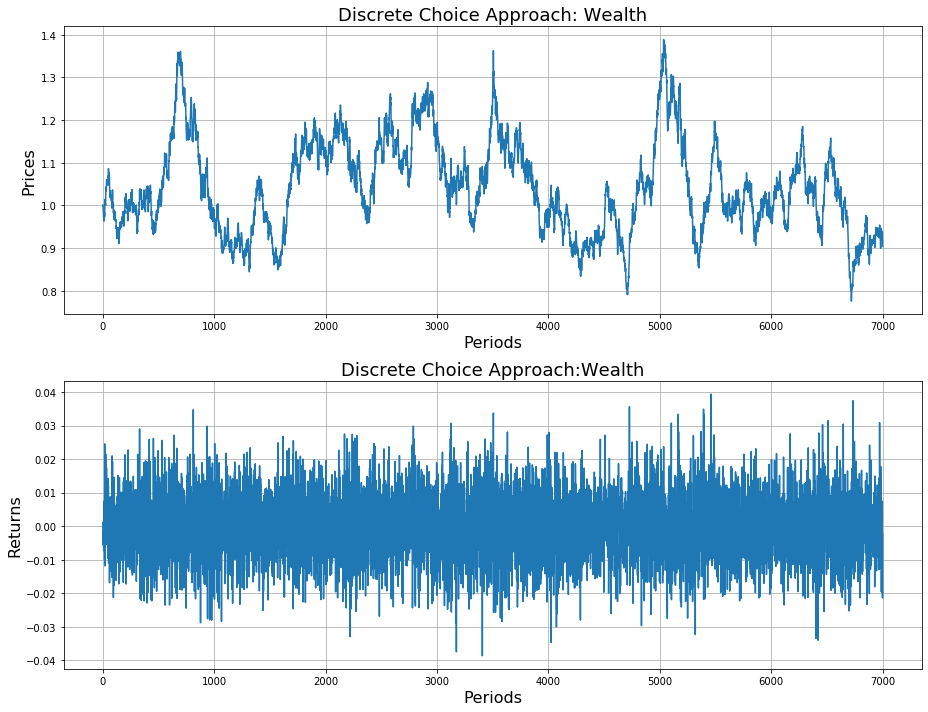

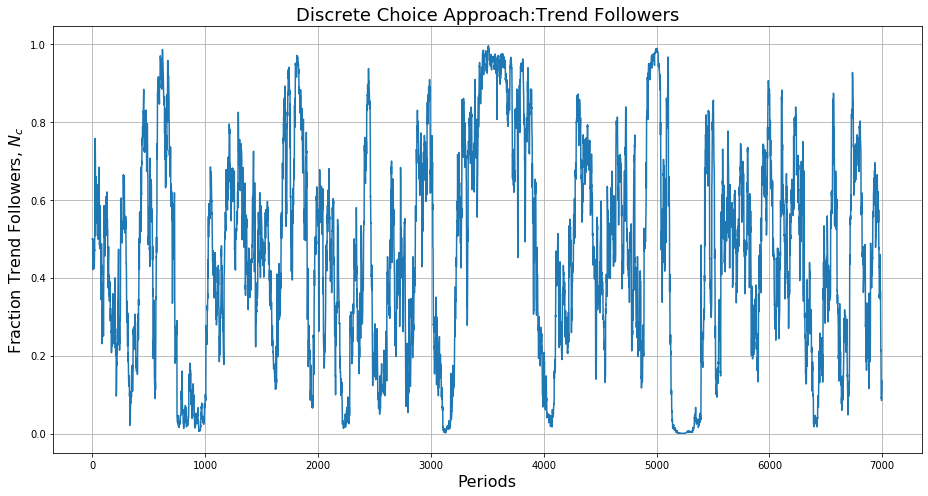

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

axes[0].plot(range(len(P[1:])), np.exp(P[1:]))
axes[0].set_xlabel('Periods', fontsize=16)
axes[0].set_ylabel('Prices', fontsize=16)
axes[0].set_title('Discrete Choice Approach: Wealth', fontsize=18)
axes[0].grid()

axes[1].plot(range(len(rr)), rr)
axes[1].set_xlabel('Periods', fontsize=16)
axes[1].set_ylabel('Returns', fontsize=16)
axes[1].set_title('Discrete Choice Approach:Wealth', fontsize=18)
axes[1].grid()

fig.tight_layout()

fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes1.plot(range(len(rr)), results[2])
axes1.set_xlabel('Periods', fontsize=16)
axes1.set_ylabel('Fraction Trend Followers, $N_{c}$', fontsize=16)
axes1.set_title('Discrete Choice Approach:Trend Followers', fontsize=18)
axes1.grid()

fig1.tight_layout()

# TPA (Transition Probability Approach)

In [16]:
# Given Parameters
params_tpa = {'mu' : 0.01, 
              'v' : 0.05, 
              'phi' : 1.15, 
              'chi' : 0.81, 
              'eta' : 0.987
             }

In [17]:
def run_simple_model_tpa(params, T = 7000):
    
    alpha_w, sigma_f, sigma_c = 1041, 0.715, 1.528
    
    P = np.zeros([T+1,1])
    pstar = 0

    Df = np.zeros([T,1])
    Dc = np.zeros([T,1])

    Nf = np.zeros([T,1])
    Nc = np.zeros([T,1])
    
    Pi_cf = np.zeros([T,1])
    Pi_fc = np.zeros([T,1])

    rf = np.zeros([T,1])
    rc = np.zeros([T,1])

    Wf = np.zeros([T,1])
    Wc = np.zeros([T,1])

    A = np.zeros([T,1])
    
    # initial values(not given)
    Nf[0:2] = 0.5
    Nc[0:2] = 0.5
    Pi_cf[0:2] = 0.5
    Pi_fc[0:2] = 0.5
    
    for t in range(2, T):

        #portfolio performance
        rf[t] = (np.exp(P[t]) - np.exp(P[t-1])) * Df[t-2]
        rc[t] = (np.exp(P[t]) - np.exp(P[t-1])) * Dc[t-2]

        #summarize performance over time
        Wf[t] = params['eta'] * Wf[t-1] + (1 - params['eta']) * rf[t]
        Wc[t] = params['eta'] * Wc[t-1] + (1 - params['eta']) * rc[t]
        
        #Determine transition probabilities
        Pi_cf[t] = np.minimum(1, params['v'] * np.exp(A[t-1]))
        Pi_fc[t] = np.minimum(1, params['v'] * np.exp(-A[t-1]))

        #TPA dynamics
        Nf[t] = Nf[t-1] + Nc[t-1] * Pi_cf[t] - Nf[t-1] * Pi_fc[t]
        Nc[t] = 1 - Nf[t]

        # The A[t] dynamic
        A[t] = alpha_w * (Wf[t] - Wc[t])

        # demands
        Df[t] = params['phi'] * ( pstar - P[t] ) + sigma_f * np.random.randn(1)
        Dc[t] = params['chi'] * ( P[t] - P[t-1] ) + sigma_c * np.random.randn(1)

        # pricing
        P[t+1] = P[t] + params['mu'] * ( Nf[t] * Df[t] + Nc[t] * Dc[t] )

    # returns
    rr = P[1:T+1] - P[0:T]
    
    return [P, rr, Nc, Nf]

In [18]:
results = run_simple_model_tpa(params_tpa)
P, rr = results[0], results[1]
results_dict['Skew'].append(stats.skew(rr)[0])
results_dict['Kurtosis'].append(stats.kurtosis(rr)[0])
results_dict['Sum(ACF)'].append(np.sum(acf(abs(rr), unbiased=True, nlags=250)))

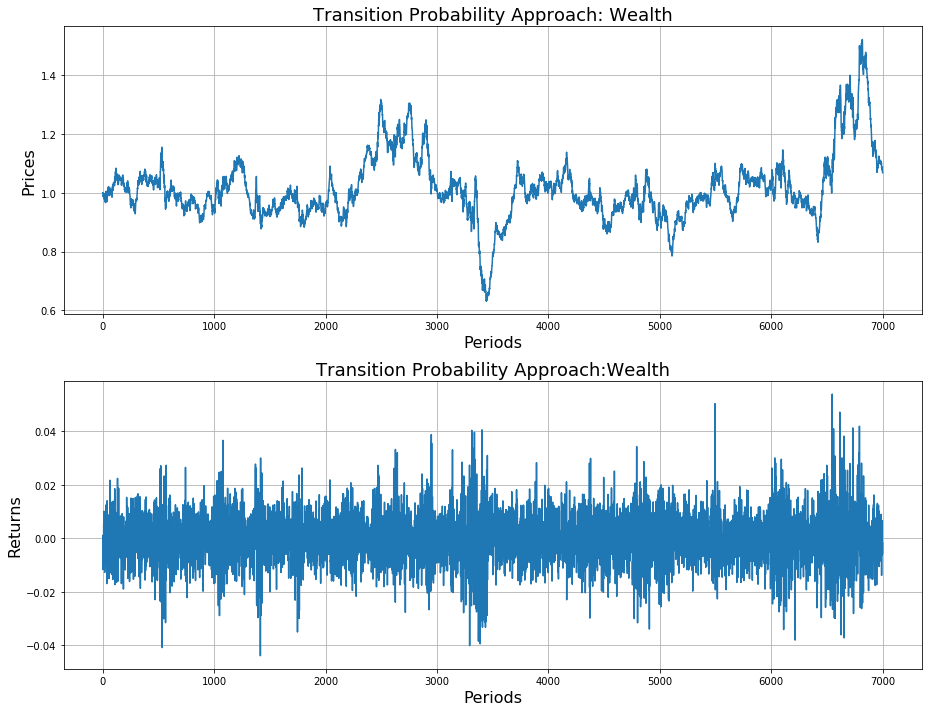

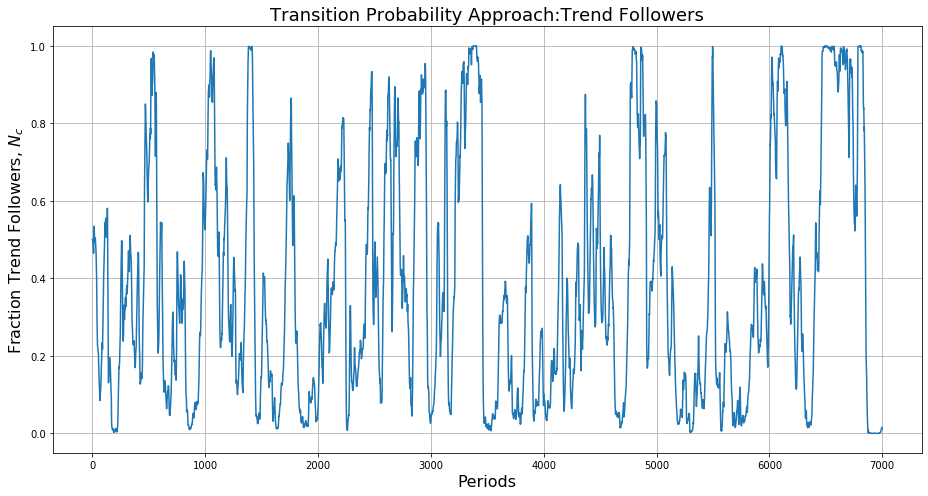

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13,10))

axes[0].plot(range(len(P[1:])), np.exp(P[1:]))
axes[0].set_xlabel('Periods', fontsize=16)
axes[0].set_ylabel('Prices', fontsize=16)
axes[0].set_title('Transition Probability Approach: Wealth', fontsize=18)
axes[0].grid()

axes[1].plot(range(len(rr)), rr)
axes[1].set_xlabel('Periods', fontsize=16)
axes[1].set_ylabel('Returns', fontsize=16)
axes[1].set_title('Transition Probability Approach:Wealth', fontsize=18)
axes[1].grid()

fig.tight_layout()

fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes1.plot(range(len(rr)), results[2])
axes1.set_xlabel('Periods', fontsize=16)
axes1.set_ylabel('Fraction Trend Followers, $N_{c}$', fontsize=16)
axes1.set_title('Transition Probability Approach:Trend Followers', fontsize=18)
axes1.grid()

fig1.tight_layout()

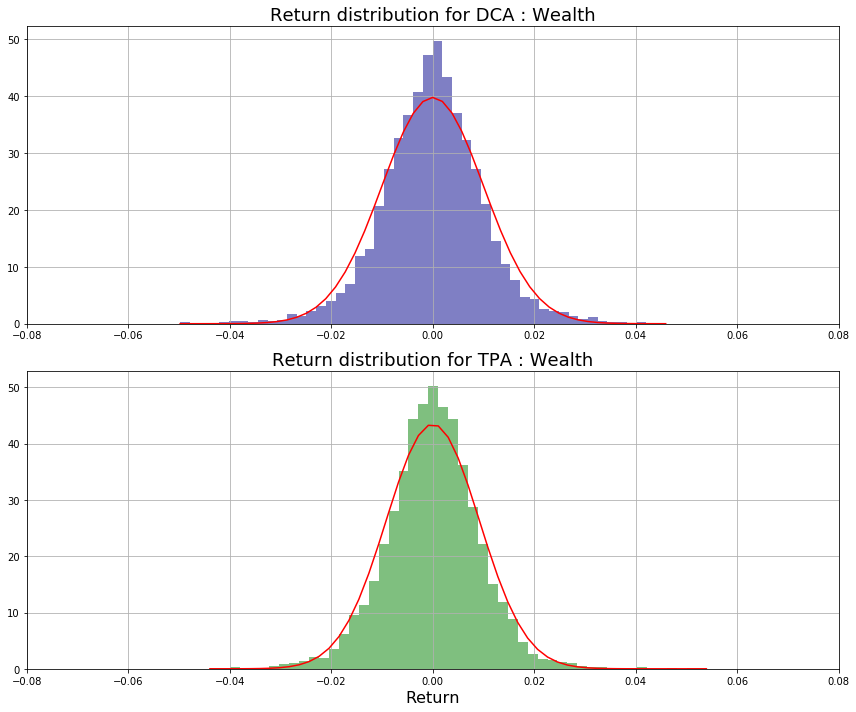

In [20]:
fig2, axes2 = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

y = returns_dca[0]
n, bins, patches = axes2[0].hist(returns_dca[0], bins=50, density=1, alpha=0.5, facecolor="darkblue")
mu = np.average(y)
sigma = np.std(y)
axes2[0].plot(bins, ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2)), '-', color='red')
axes2[0].set_title(u'Return distribution for DCA : Wealth', fontsize=18)
axes2[0].set_xlim([-0.08, 0.08])
axes2[0].grid()

y = rr
n, bins, patches = axes2[1].hist(rr, bins=50, density=1, alpha=0.5, facecolor="green")
mu = np.average(y)
sigma = np.std(y)
axes2[1].plot(bins, ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2)), '-', color='red')
axes2[1].set_title(u'Return distribution for TPA : Wealth', fontsize=18)
axes2[1].set_xlim([-0.08, 0.08])
axes2[1].set_xlabel('Return', fontsize=16)
axes2[1].grid()

fig2.tight_layout()

## Return Autocorrelation

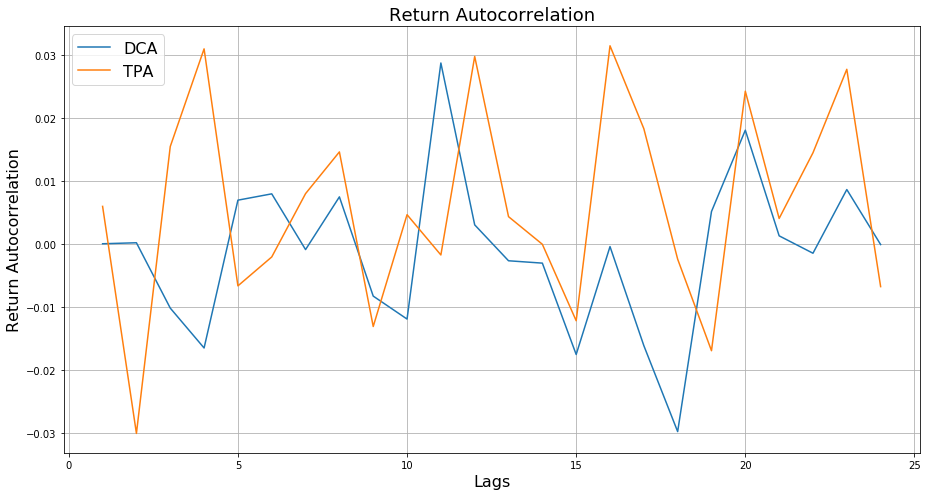

In [21]:
x = pd.Series(returns_dca[0].squeeze())
y = pd.Series(rr.squeeze())

autocorr_dca = [x.autocorr(lag=i) for i in range(1, 25)]
autocorr_tpa = [y.autocorr(lag=i) for i in range(1, 25)]

fig3, axes3 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes3.plot(range(1, 25), autocorr_dca, label='DCA')
axes3.plot(range(1, 25), autocorr_tpa, label='TPA')
axes3.set_xlabel('Lags', fontsize=16)
axes3.set_ylabel('Return Autocorrelation', fontsize=16)
axes3.set_title('Return Autocorrelation', fontsize=18)
axes3.legend(prop={'size': 16})
axes3.grid()

fig3.tight_layout()

## Absolute Return Autocorrelation

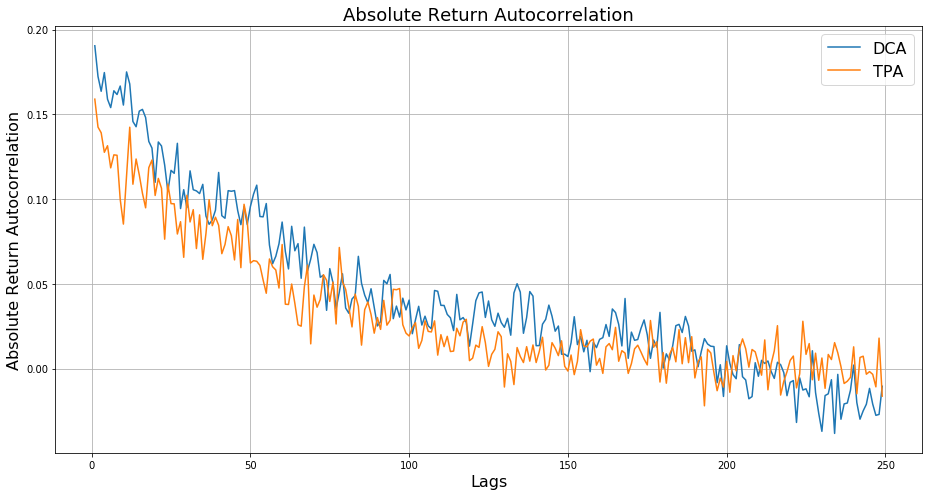

In [22]:
x = pd.Series(np.abs(returns_dca[0].squeeze()))
y = pd.Series(np.abs(rr.squeeze()))

autocorr_dca = [x.autocorr(lag=i) for i in range(1, 250)]
autocorr_tpa = [y.autocorr(lag=i) for i in range(1, 250)]

fig3, axes3 = plt.subplots(nrows=1, ncols=1, figsize=(13,7))

axes3.plot(range(1, 250), autocorr_dca, label='DCA')
axes3.plot(range(1, 250), autocorr_tpa, label='TPA')
axes3.set_xlabel('Lags', fontsize=16)
axes3.set_ylabel('Absolute Return Autocorrelation', fontsize=16)
axes3.set_title('Absolute Return Autocorrelation', fontsize=18)
axes3.legend(prop={'size': 16})
axes3.grid()

fig3.tight_layout()

# Model Comparison

In [23]:
df = pd.DataFrame(results_dict, index=['DCA', 'DCA-P', 'DCA-M', 'DCA-CN', 'TPA'])
df = df.round(2)
df = df.sort_values(by='Sum(ACF)', ascending=False)
display(df)

,Skew,Kurtosis,Sum(ACF)
DCA-P,0.00,3.06,15.75
DCA,-0.03,1.70,11.79
TPA,0.02,1.66,9.11
DCA-M,0.07,1.17,3.27
DCA-CN,0.01,0.15,2.14
